# Dimensionality Reduction with Regression

In [1]:
import numpy as np
from sklearn.utils import check_random_state
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from time import time 

%matplotlib inline

## Create Data

In [2]:
# create noisy helix
amplitude_a = 3
scale_a = 4
amplitude_b = 2
scale_b = 4
num_points = 1000
t_time = np.linspace(0, np.pi, num_points)
x_data = amplitude_a * np.cos(scale_a * t_time)
y_data = amplitude_b * np.sin(scale_b * t_time)
z_data = amplitude_b * t_time

helix_data = np.vstack((x_data, y_data, z_data)).T
helix_data_test = helix_data.copy()
n_samples, d_dimensions = helix_data.shape
# add noise
random_state = 123
generator = check_random_state(random_state)
noise_scale = np.linspace(0.1, 1.8, len(t_time))


helix_data += (generator.randn(n_samples, d_dimensions).T * noise_scale).T

generator_test = check_random_state(111)
helix_data_test += (generator_test.randn(n_samples, d_dimensions).T * noise_scale).T

In [3]:

scale = noise_scale
noise = generator.randn(n_samples, d_dimensions)

print(scale.shape)
print(noise.T.shape)

temp = scale * noise.T

print(temp.shape)



(1000,)
(3, 1000)
(3, 1000)


### Figure

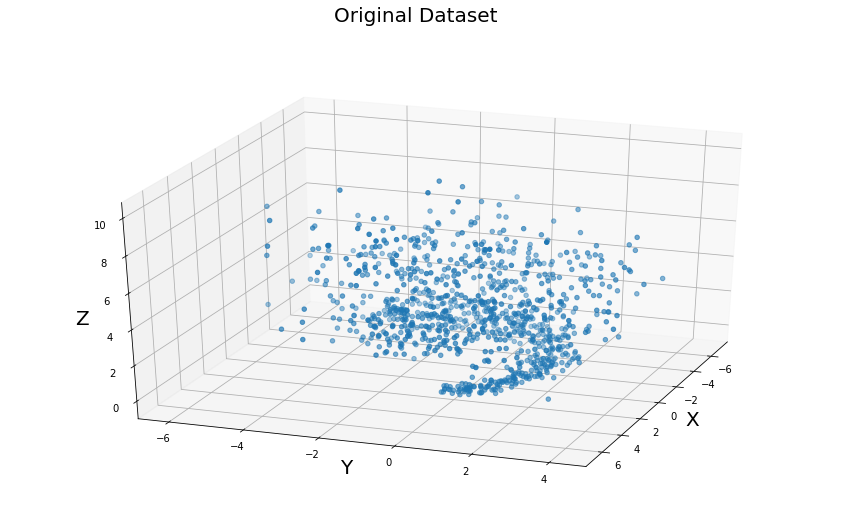

In [4]:
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Original Dataset", fontsize=20)

ax = fig.add_subplot(111, projection='3d')

ax.scatter(helix_data[:, 0], 
           helix_data[:, 1], 
           helix_data[:, 2])
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)

ax.view_init(30, 20)
plt.show()

## PCA

In [5]:
trans_train = 'PCA' # PCA, ICA, MCV

# extract the mean of the data
data_mean = np.mean(helix_data, axis=0)
helix_data_mean = helix_data - data_mean

# PCA on the data 
cov_data = np.cov(helix_data_mean, rowvar=False)  # covariance matrix
[eigvals, eigvecs] = np.linalg.eig(cov_data)  # eigenvalues

print('Shape of cov data: ', cov_data.shape)
print('Shape of eigvals, eigvecs data: ', 
      eigvals.shape, eigvecs.shape)

Shape of cov data:  (3, 3)
Shape of eigvals, eigvecs data:  (3,) (3, 3)


In [6]:
PCA_Model = PCA(random_state=random_state, svd_solver='full')
PCA_Model.fit(helix_data)
eigvecs_pca = PCA_Model.components_
eigvals_pca = PCA_Model.singular_values_
cov_pca = PCA_Model.get_covariance()
mean_pca = PCA_Model.mean_

print(eigvals_pca.shape, eigvecs_pca.shape)

(3,) (3, 3)


In [7]:
print('Covariances the same?: ', np.allclose(cov_pca, cov_data))
print('Means the same?: ', np.allclose(data_mean, mean_pca))

Covariances the same?:  True
Means the same?:  True


In [8]:
print(eigvecs.shape)
print(eigvals.shape)
indices = eigvals.argsort()
eigvals_sorted = eigvals[indices]
eigvecs_sorted = eigvecs[:, indices]

print(eigvals_sorted)


indices = eigvals_pca.argsort()
eigvals_pca_sorted = eigvals_pca[indices]
eigvecs_pca_sorted = eigvecs_pca[:, indices]

print(eigvals_pca_sorted)

(3, 3)
(3,)
[ 2.62969655  4.93535489  5.57510028]
[ 51.25492028  70.21694623  74.62925148]


In [9]:
print('Eigenvalues the same?: ', np.allclose(eigvals_sorted, 
                                             eigvals_pca_sorted))
print('Eigenvalues manually: ', eigvals)
print('Eigenvalues scikit-learn: ', eigvals_pca)
print('Eigenvalues manually: ', eigvals_sorted)
print('Eigenvalues scikit-learn: ', eigvals_pca_sorted)

Eigenvalues the same?:  False
Eigenvalues manually:  [ 5.57510028  4.93535489  2.62969655]
Eigenvalues scikit-learn:  [ 74.62925148  70.21694623  51.25492028]
Eigenvalues manually:  [ 2.62969655  4.93535489  5.57510028]
Eigenvalues scikit-learn:  [ 51.25492028  70.21694623  74.62925148]


In [10]:
print('Eigenvectors the same?: ', np.allclose(eigvecs_sorted, 
                                              eigvecs_pca_sorted))
print('Eigenvectors manually: ', eigvecs_sorted)
print('Eigenvectors scikit-learn: ', eigvecs_pca_sorted)

Eigenvectors the same?:  False
Eigenvectors manually:  [[  6.15492078e-05  -1.02021003e-01  -9.94782243e-01]
 [  8.70585172e-01   4.89455977e-01  -5.01428389e-02]
 [  4.92017738e-01  -8.66039584e-01   8.88480978e-02]]
Eigenvectors scikit-learn:  [[  8.88480978e-02  -5.01428389e-02  -9.94782243e-01]
 [  8.66039584e-01  -4.89455977e-01   1.02021003e-01]
 [  4.92017738e-01   8.70585172e-01   6.15492078e-05]]


In [11]:
# transform data
data_pca = (eigvecs_sorted @ helix_data_mean.T).T

print('Shape of data after PCA: ', data_pca.shape)


print(data_pca.shape)
print(data_pca.dtype)

Shape of data after PCA:  (1000, 3)
(1000, 3)
float64


## Kernel Ridge Regression

**Note**: Figure out what the KRR is actually training for...

**TODO**:

* Clarification on the training and testing
* The order of the training: does it matter?
* PCA results check

In [12]:
data_pca_aux = data_pca.copy()
data_transformed = np.zeros(data_pca.shape)

KRR_Models = []
time_results = []

for idim in np.arange(0, d_dimensions-1):
    
    # get the test dimension
    label_dimension = data_pca.shape[1] - idim - 1
    print('Label Dimension: ', label_dimension)
    
    # get the train dimension
    data_dimensions = \
        np.setdiff1d(np.arange(0, data_pca_aux.shape[1]), label_dimension)
    
    print('Train Dimensions: ', data_dimensions)
    
    # parameter grid
    param_grid = {
        "alpha": [1e0, 0.1, 1e-2, 1e-3],
        "gamma": np.logspace(-2, 2, 5)}
    n_folds = 5
    
    t0 = time()
    # initialize kernel model with brute force grid search
    KRR_Model = GridSearchCV(KernelRidge(kernel='rbf'), 
                             cv=5,
                             n_jobs=-1,
                             param_grid=param_grid)
    
    # extract data from training, testing
    x_train = data_pca[:, data_dimensions]
    y_train = data_pca[:, label_dimension]
    x_test = data_pca[:, data_dimensions]
    
    # fit model
    KRR_Model.fit(x_train, y_train)
    
    # predict
    ypred = KRR_Model.predict(x_test)
    
    t1 = time() - t0
    # save krr model
    KRR_Models.append(KRR_Model)
    time_results.append(t1)
    
    
    data_pca_aux = data_pca_aux[:, data_dimensions]
    data_transformed[:, d_dimensions - idim - 1] = \
            data_pca[:, label_dimension] - ypred

data_transformed[:, 0] = data_pca_aux[:, 0]

Label Dimension:  2
Train Dimensions:  [0 1]
Label Dimension:  1
Train Dimensions:  [0]


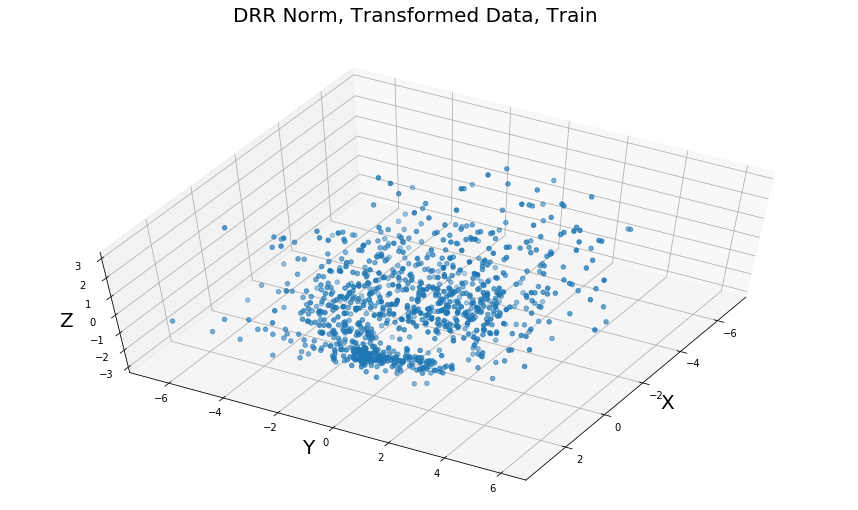

In [13]:
fig = plt.figure(figsize=(15, 8))
plt.suptitle("DRR Norm, Transformed Data, Train", fontsize=20)

ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_transformed[:, 0], 
           data_transformed[:, 1], 
           data_transformed[:, 2])
ax.set_xlabel('X', fontsize=20)
ax.set_ylabel('Y', fontsize=20)
ax.set_zlabel('Z', fontsize=20)

ax.view_init(60, 30)
plt.show()

## Apply DRR To New Data